# Full Project Report
In this report I will have a summary of my whole anaylsis up to this point. This was originally for comparison with Vera's methodology, but the only thing they really need to know about it how I calculated true cost of the Boston PD. So this document is just for our own purposes, to summarize the project thus far and look at what's left to do. 

Note that all numbers unless otherwise stated are in millions

## Introduction to Carceral Budgeting Project

Over the past couple months I've been working on this project to get the total cost of the carceral state in Suffolk County so that we can caculate the dollar cost of each case prosecuted by the Suffolk County District Attorney's Office. The government agencies that make up the incarceration system in Suffolk county are a mix of state and municipal agencies. At the state level it includes the following agencies:

- State Police
- Suffolk County Sheriff's Department
- MA Department of Correction (DOC)
- Trial Court 
- Public Counsel Services (CPCS)
- Suffolk County DA's Office
- Massachusetts Bay Transit Authority Police (MBTA Police)
- MA District Attorney Association (DAA)
- MA Sheriff's Association

The county includes four municipalities: Boston, Chelsea and Revere and Winthrop each with thier own police department 

We originally set out to look at the time period of 2016-2020 but this analysis uses some calendar year data and because the calendar year for 2020 hasn't ended yet the numbers here only go through 2019. 
The project so far includes money for the yearly operating expenses of these agencies as well as the estimated costs of the pension for each agency.

This notebook will describe the data sources, the methodology used, and then describe each state of the project in more detail including tables/plots to show the yearly operating cost of each agency and it's pension.

## Introduction to Methodology

**Yearly Operating Costs**

The methodology for the first half of the project that involves summing costs of yearly operating expenses for each agency is relatively simple. There is some nuance in because for any given year, the government will publish multiple numbers for a given agency that correspond to how much money they plan to spend as well as actual expenditures. I'll get into detail on this nuance for the various data sources but it's something we still are working on. <br>

We are missing a significant piece of data which is the MBTA police whose budget we haven't been able to find. The MBTA cops are the only entity in the project that's not defined as it's own agency, which means the public recordkeeping doesn't count it's budget on it's own line item. The best we can find for the MBTA Police is payroll data from cthru and MBTA.com for the MBTA, which is broken down by employee title. <br>

There is also some missing data on budgeted numbers for the smaller municipalities in Suffolk County which contribute a relatively small share of the total dollars. Method for filling in missing data is elaborated in the corresponding section. <br>

There is one instance of datasets that are supposed to have the same information but conflict. Both Boston and Chelsea have datasets of payroll on thier website that indicate more money being paid to cops than their published yearly budgets indicate. <br>

**Yearly Pension Costs**

Pension costs involve more estimation. There are 5 retirement systems we look at for this analysis: the MA state employees non-teacher pension fund (MSERS), plus each municipality also has it's own retirement system. For a given year, we estimate pension costs assoicated with a particular agency using a caculation that takes into account employer contributions to the pension fund that year along with a fraction (mesaured or estimated) of how much of the total retirement payouts go to retirees of that agency. At the state level we have data on retirement payments per per employee per year from cthru, at the municipal level we estimate this fraction as the fraction of total payroll dollars that go the agency in question. <br>

There are several instances of missing data and poorly organized data for this section. The most impactful issue in terms of estimating a final cost is that that the DOC retirement payouts have an accouting error that requires some estimation to fix. Additionally, I couldn't find any MBTA police retirement payouts in the cthru data. For Winthrop I couldn't find either employer contributions nor total payroll for the calculation. Workarounds are explained in detail.

**Correction for Statewide Agencies**

The biggest challenge when it comes to methodology is calculating the % of total budget that the state agencies spend on suffolk county cases. For the state agencies that work entirely within the trial system (Trial Court, public defenders, and the DA association) there's good data on how many cases per year are within Suffolk County. For the state police, DOC, and MBTA cops  we have yet to develop another methodology which is one of our next steps. So in these numbers we take 14-15% of the total budget for all statewide state agencies except 75% for MBTA cops. 



## Introduction to Data Sources 

**cthru**

cthru is a site run by the MA comptroller's office that hosts datasets related to the state budget. It has a functioning API and good documentation for each dataset. The three datasets we use from cthru are yearly expenditures, yearly budget, yearly payroll, and retirement benefits. Expenditures and budget are by fiscal year, payroll and retirement benfits are by calendar year. Data was collected using the API

**Budget PDFs**
Each municipality publishes it's yearly budget as a pdf on it's website. These budgets generally haved the planned spending the current year and actual expenditures for previous years. The Vera project on the cost of policing in Boston used numbers from the 2020 budget pdf for it's analysis. These budgets are all by fiscal year. Most data from these budget pdfs was scraped using optical character recognition with the textract library in python. 

**Earnings Datasets** 
Both Boston and Chelsea publish earnings datasets on thier websites. These are downloaded as .csv files. They are organized by calendar year. 

**MBTA.com**
Has a couple spreadsheets of MBTA yearly payroll data which fills in some gaps where payroll data for MBTA is missing from cthru

**ma.gov**
This site has trial court statistics used to calculate % of total resources trial court spends on Suffolk County. May have other useful statistics that help develop similar corrections for DOC, state police, and MBTA police.

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 18), "lines.linewidth": 5})
sns.set_style("darkgrid")

# Yearly Operating Budget

This section details calculating the cost of year-to-year operation of the 13 agencies we look at. These costs make up 85-90% of the final total cost, with pensions making up the rest

## Yearly Operating Budget of State Agencies

This section requires two steps, taking numbers on total cost from cthru and then correting for what % of that money spent on statewide agencies ultimately is spent on Suffolk cases.<br>

All data is from cthru except for MBTA Police numbers. For this part of the project we use a calculation of yearly budget. The reason we decided to use yearly budget instead of expenditures for this stage is that the recordkeeping is detailed enough to break down money from the yearly spending bill (MA General Appropriations Act or GAA), other spending bills, and revenues that these agencies collect on thier own. <br>

**Notes on missing data**
The MBTA police data comes from soley from payroll numbers, for 2017 the payroll numbers come from the MBTA website and for 2018 and 2019 from cthru's payroll dataset. For 2016 I used the 2015 payroll numbers from the MBTA's website in accordance with the methodology of using the previous year's data for years with missing data. We are missing the cost of the MBTA's non-labor expenses in this section but I don't have a good way to estimate them. I thought about using the assumption that the MBTA police has a similar ratio of labor to non-labor expenses as another police force but I don't know if that's a good assumption.


I'm considering changing the methodology in a big way for this section and looking at expenditures for each year instead of budget. The reason to do this is consistensy, for the local police departments we should definitely use expenditures so we can use the correct payroll numbers from the earnings datasets. 

In [21]:
from Full_Project_Reportback_1Ver import plot_state_agencies_budget, plot_over_time
year_range = list(range(2016, 2020))

Yearly State Agency Operating Costs in Suffolk County in Millions


,Category,2016,2017,2018,2019
trial_court,Legal,92.583,91.282,95.801,97.273
CPCS,Legal,31.644,32.844,25.308,35.625
DOC,Jails,88.269,89.939,97.548,98.915
Suffolk_DA,Legal,18.251,19.282,19.470,20.975
Suffolk_Sheriff,Jails,104.492,103.447,105.516,106.572
State_Police,Police,52.911,53.089,57.038,53.769
MBTA Police,Police,21.106,16.997,18.163,23.730
DAA,Legal,1.171,0.743,0.681,1.286
MA Sheriff's Association,Police,0.056,0.054,0.055,0.065
Total of State Agencies,NaN,410.483,407.677,419.581,438.212


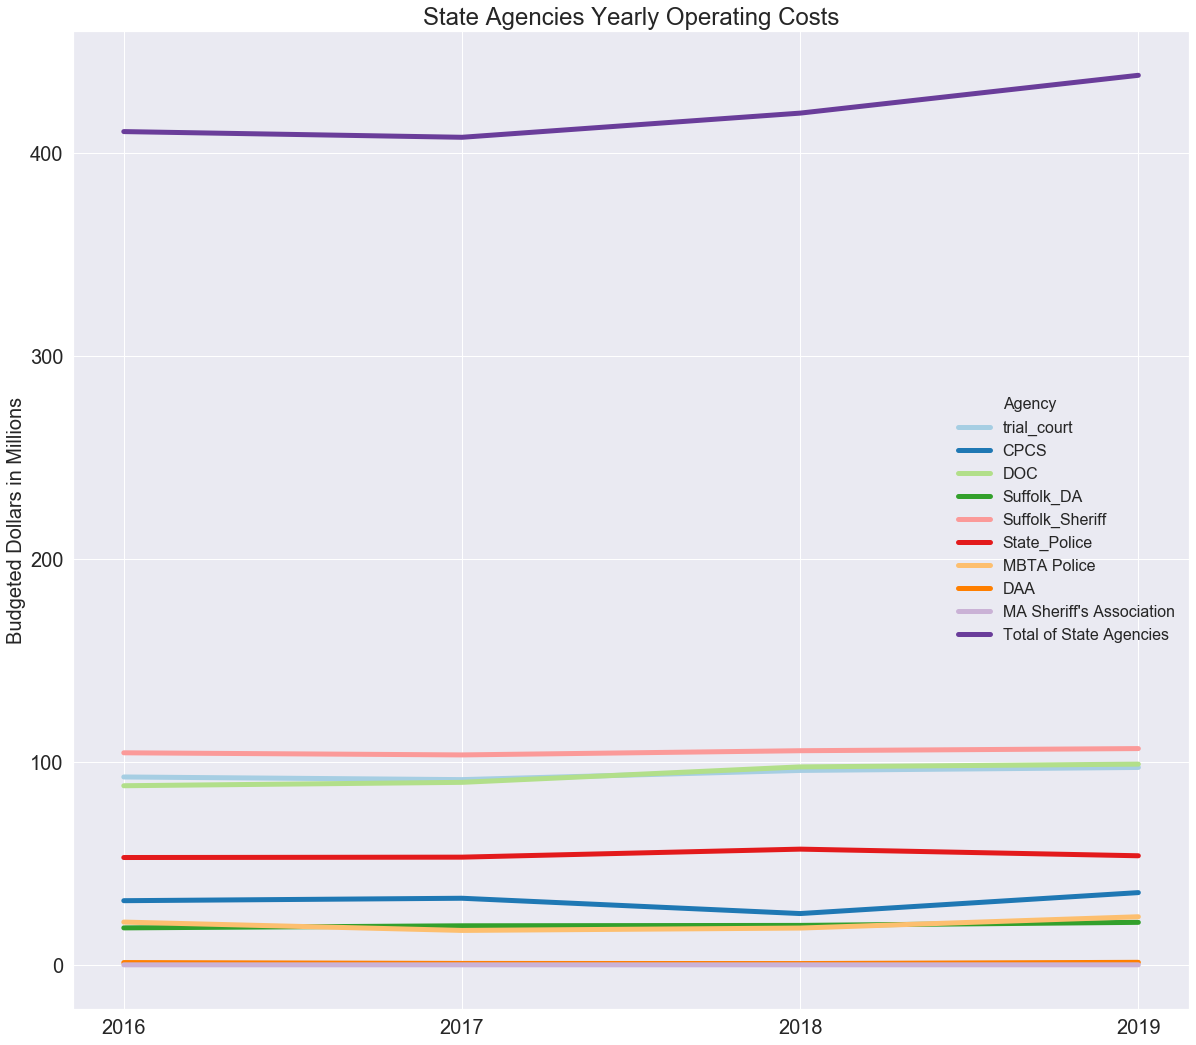

In [22]:
print("Yearly State Agency Operating Costs in Suffolk County in Millions")
plot_state_agencies_budget()

## Municipal Police Departments Budget PDFs
For this section we look at expenditures instead of budgets. There is no advantage of extra detail in the budget numbers. Additionally, when we add in true payroll expenditures it makes the most sense to have a final number that comes entirely from expenditures

Summary of Missing Data:

- Chelsea Total Expenditures 2016 not found, use Total Budget instead (less than 1% difference on net between the two the years we have data for 2017-2019)
- Revere Total Expenditures 2019 not found, use total Budget instead (less than 1% on difference on net between the two years we have the data for 2016-2018
- Winthrop Total Expenditures 2018 not found, use total budget instead (less than 1% difference between total budget and total expenditures for the one year we have both)




In [23]:
from Full_Project_Reportback_1Ver import localPD_budget_pdfs

,2016,2017,2018,2019
Boston PD,363.892,383.007,427.257,432.785
Chelsea PD,10.909,10.417,10.795,12.166
Revere PD,10.079,9.706,10.725,10.719
Winthrop PD,3.038,3.191,3.501,4.037


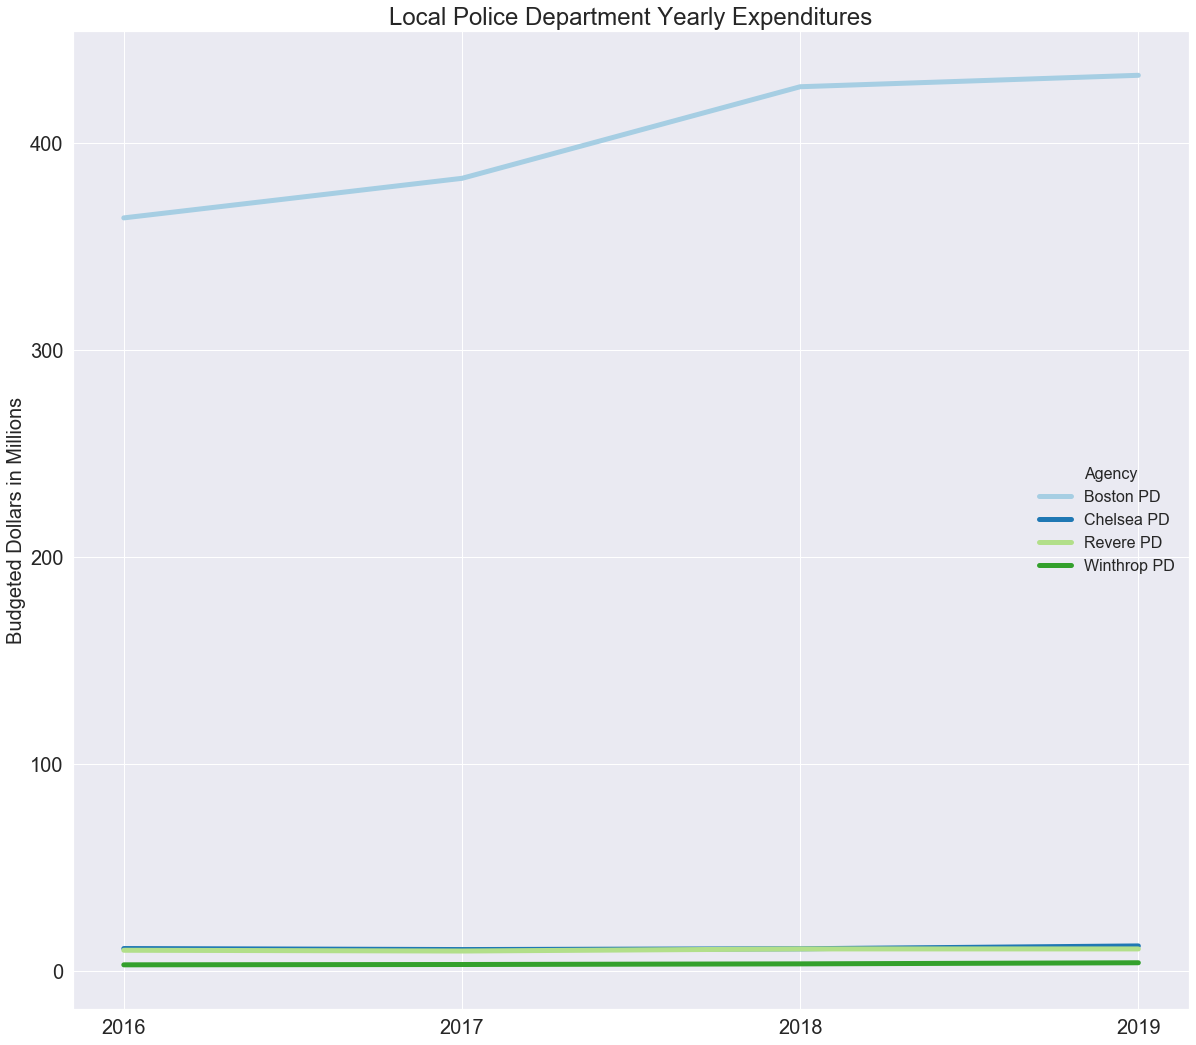

In [24]:
localPD = localPD_budget_pdfs()


Unsurpisingly, dominated by Boston PD

## Boston and Chelsea Actual Earnings

Boston makes this data availible for the entire year range we are looking at, for Chelsea it only goes back to 2017. In both datasets police employees are clearly marked so there are no concerns about missing data there

In [25]:
from Full_Project_Reportback_1Ver import compare_true_earnings


,2016,2017,2018,2019
Boston PD Total Expenditures from Yearly Budget,363.892,383.007,427.257,432.785
Boston PD Payroll Expenditures from Yearly Budget,323.996,336.077,361.057,374.731
Boston PD True Payroll,388.587,391.278,416.683,415.726
Chelsea PD Total Expenditures from Yearly Budget,10.909,10.417,10.795,12.166
Chelsea PD Payroll Expenditures from Yearly Budget,9.686,9.552,9.923,11.526
Chelsea PD True Payroll,nan,12.028,12.650,14.610


Difference between Earnings Dataset and Stated Yearly Payroll for Boston


2016   64.591
2017   55.200
2018   55.626
2019   40.995
dtype: float64

Difference between Earnings Dataset and Stated Yearly Payroll for Chelsea


2016     nan
2017   2.476
2018   2.727
2019   3.084
dtype: float64

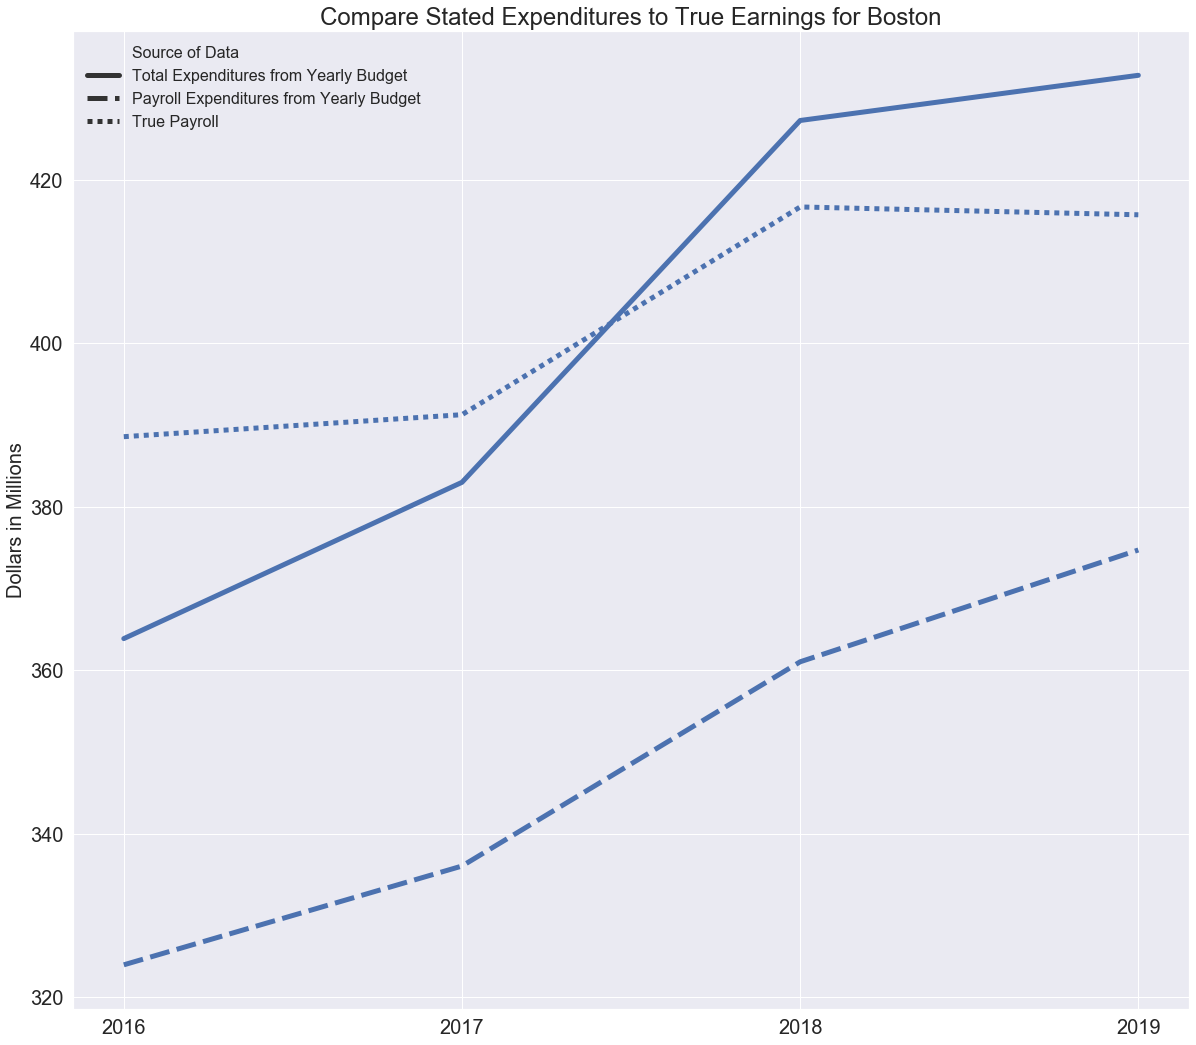

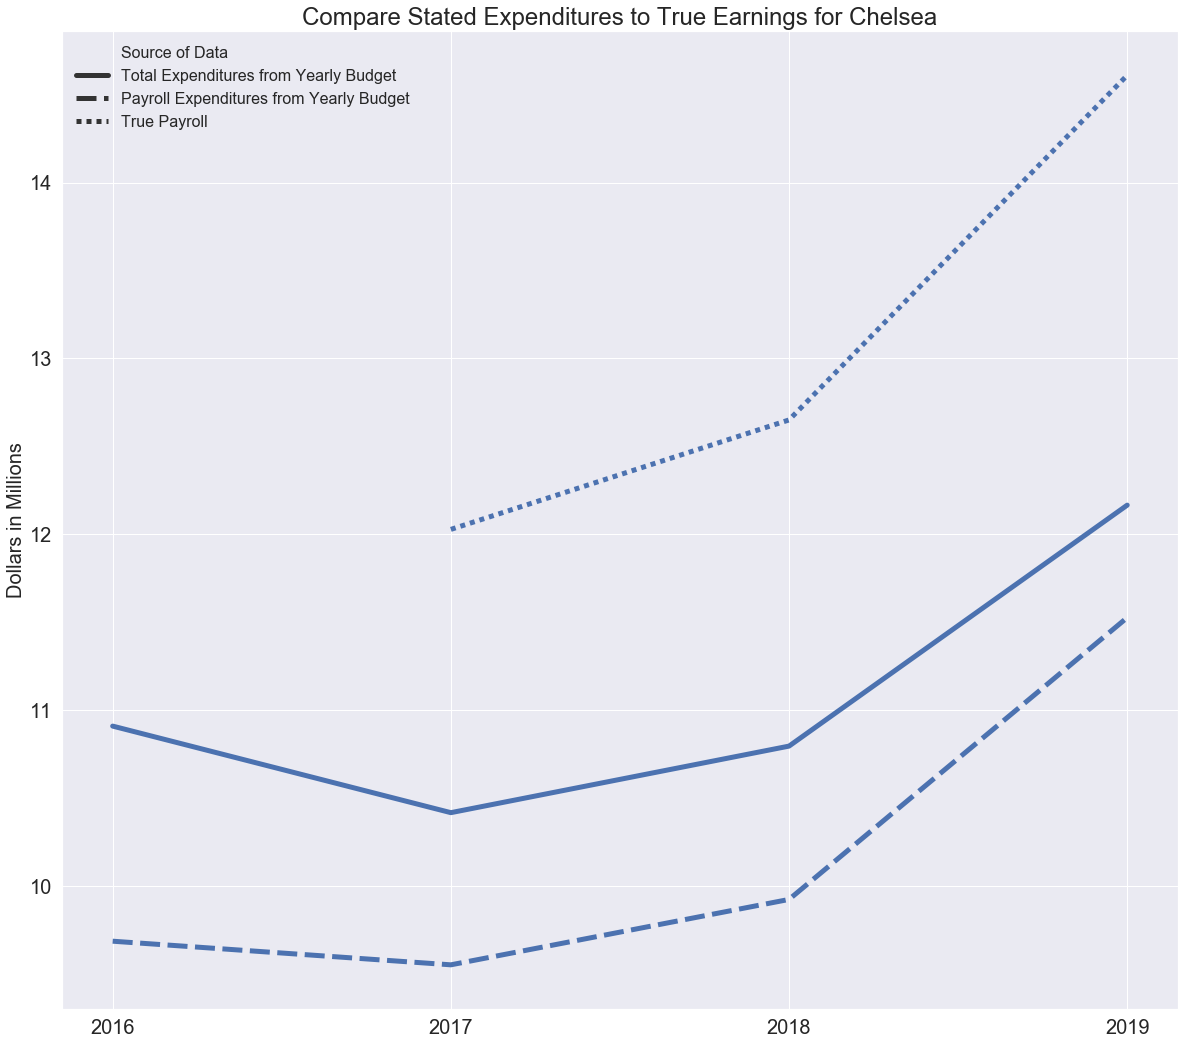

In [26]:
compare_true_earnings()

When the earnings data is used as "correct" payroll, the true cost of the Boston PD increases by 40-60 million dollars per year. <br>
For Chelsea it goes up another 2 or 3 million. If we had similar data for Revere the yearly cost would presumably go up a similar amount as Revere and Chelsea have similarly sized departments but I can't find an earnings dataset for Revere. <br>
These earning numbers are the first instance of what we refer to as "hidden costs," which is a term for all money that doesn't show up in the yearly spending numbers.

## Summary of Part 1: Yearly Operating Costs
Here I'll plot the total yearly opearating costs of all 13 agencies, the cost per SCDAO cases each year, and the % change since 2016.

In [27]:
from Full_Project_Reportback_1Ver import visualize_yearly_operating_costs

,Category,2016,2017,2018,2019
trial_court,Legal,92.583,91.282,95.801,97.273
CPCS,Legal,31.644,32.844,25.308,35.625
DOC,Jails,88.269,89.939,97.548,98.915
Suffolk_DA,Legal,18.251,19.282,19.470,20.975
Suffolk_Sheriff,Jails,104.492,103.447,105.516,106.572
State_Police,State Police,52.911,53.089,57.038,53.769
MBTA Police,State Police,21.106,16.997,18.163,23.730
DAA,Legal,1.171,0.743,0.681,1.286
MA Sheriff's Association,State Police,0.056,0.054,0.055,0.065
Boston PD,Local PD,428.483,438.207,482.883,473.780


,2016,2017,2018,2019
Category,,,,
Jails,192.761,193.386,203.065,205.487
Legal,143.650,144.151,141.260,155.159
Local PD,452.509,463.997,510.631,503.785
State Police,74.072,70.139,75.257,77.565


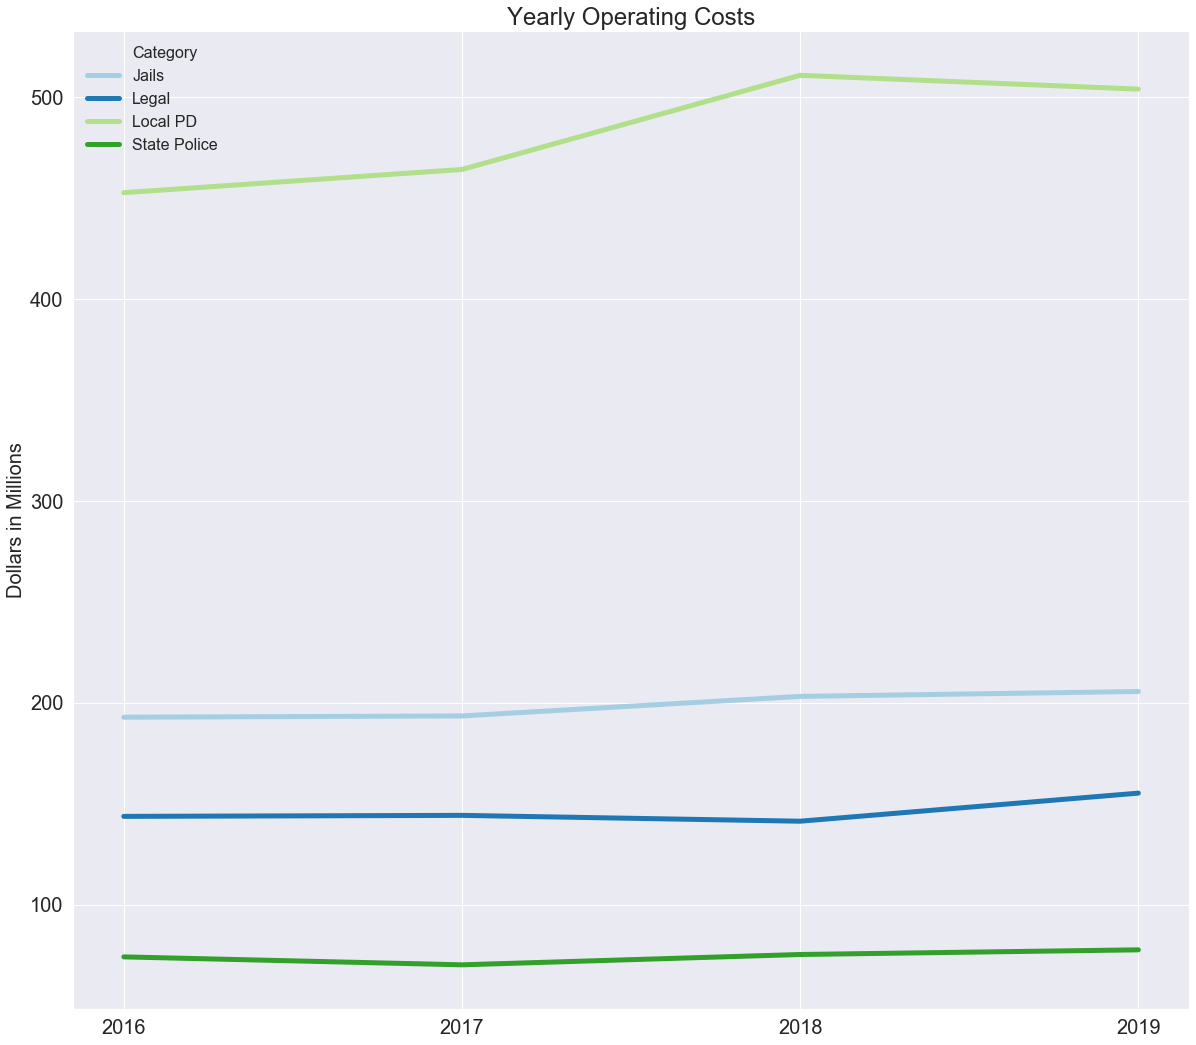

Cost per SCDAO Case (In Thousands)


2016   28051.092
2017   30840.441
2018   33439.228
2019   35445.384
dtype: float64

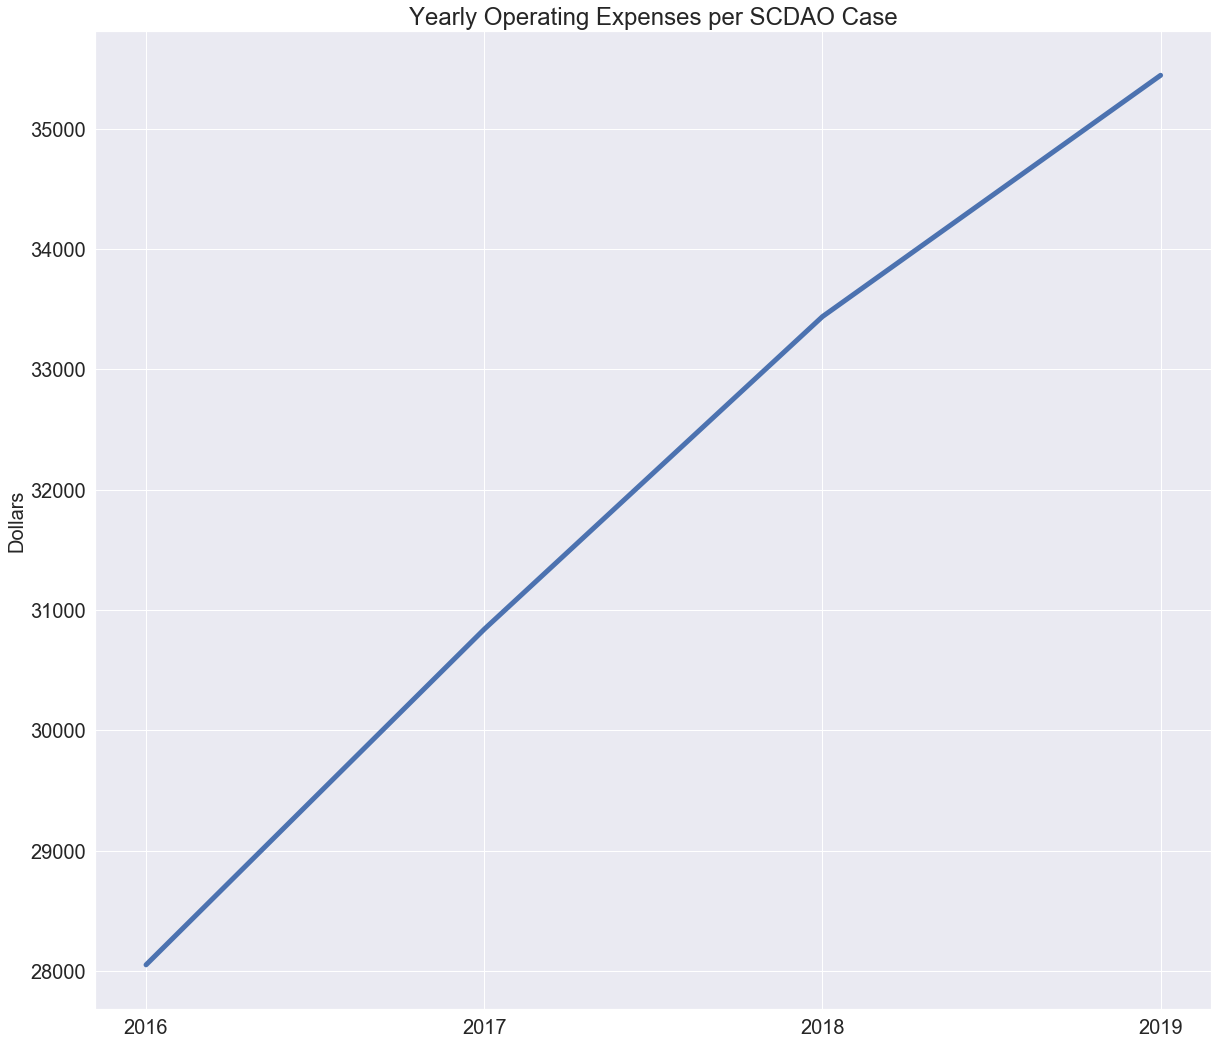

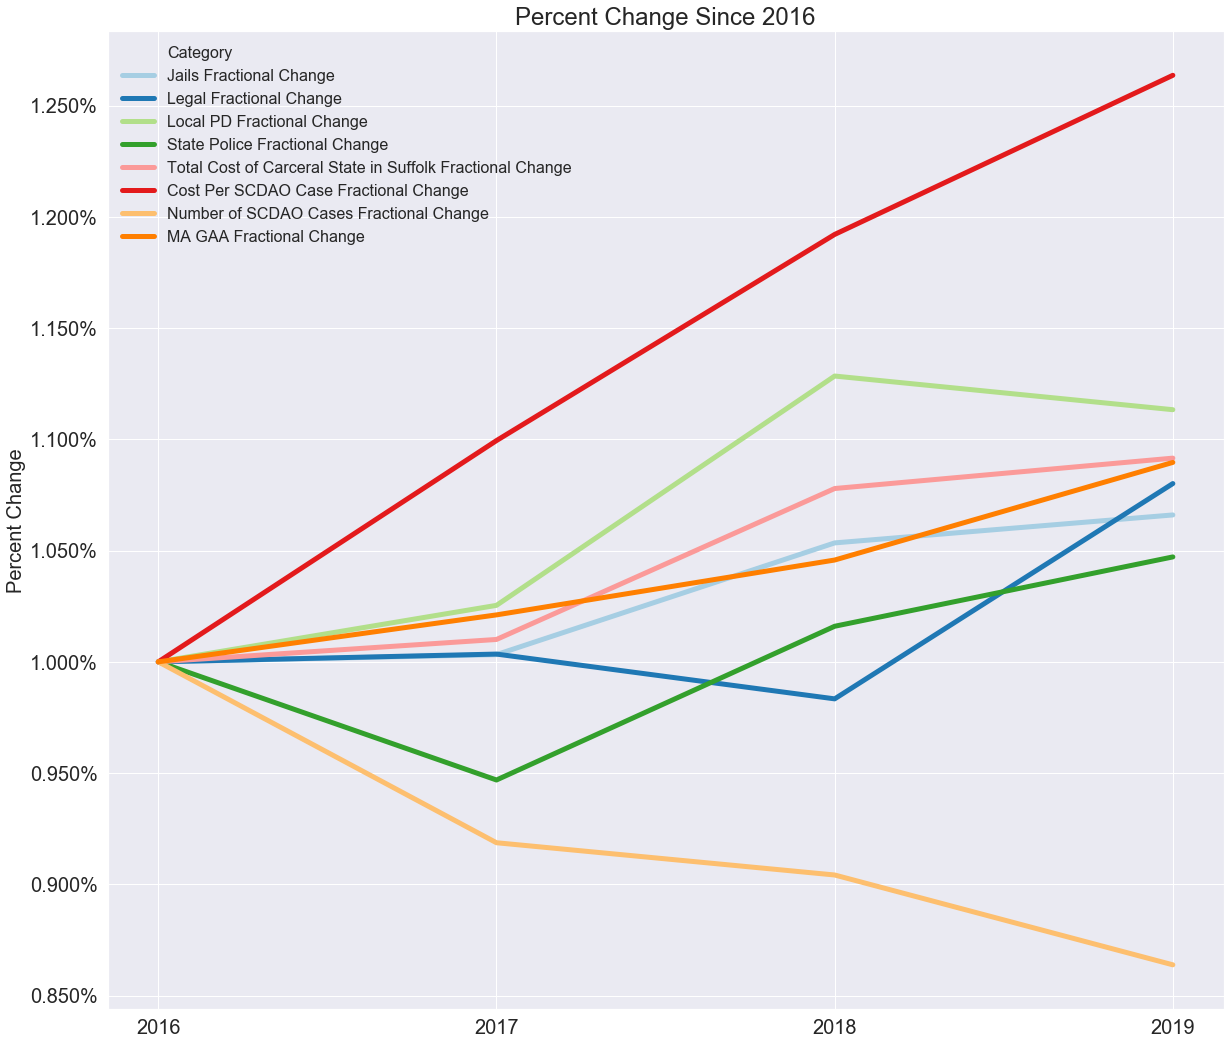

In [28]:
visualize_yearly_operating_costs()

That concludes the section on yearly costs of actually running these agencies. <br>
I'm leaning towards switching the methodology towards just measuring expenditures for everything and not looking at the budgets. It won't change the final numbers much and it will make the whole anaylsis more consistent.

# Pension Costs 

## State Agency Pension Costs
Like the last section, I'll start with the state agencies because cthru gives more detailed data.<br>

For this part of the project we use two new sources of data:
- A dataset of yearly retirement benefit payouts broken down by where the employee last worked and calendar year
- State Expenditures to the state employees pension fund from the cthru expenditures dataset

Because the money paid out in retirement benefits is a combination of employee contributions, employer contribution, and the pension fund's ROI we can't just count retirement benefits paid to cops, trial court judges ADA's etc as direct costs of the carceral system. So the methodology is to take the % of total Massachusset State Retirement system (not including teacher retirement payouts which go through a different system) that are paid out to the agencies we are looking at. <br>

**Notes on missing data**<br>

The first issue is that I can't find pensions for MBTA cops. I looked for the department of Massachussets Dept of Transportation and MBTA under the department column and also looked for employees whose titled included "police" but didn't work for any of the agencies listed in this report. <br>

The second issue with missing data is the Massachussets DOC. The data says there are 160 million dollars in pension costs paid out in 2020 while 6-11 million was paid out in the previous years (check this). I assumed that this was a book keeping error and that the 2020 dollars were meant to spread out over some larger number of years. The dataset went back to 2011, so it seems plausible that the 160 million dollar 2020 payout was supposed to be spread out over 2011-2020. So for each year 2011-2020 I calculated the % of money paid out to former DOC employees in that year out of the total money paid out to former DOC employees (not including that lump sum) and distributed the lump sum according to that fraction. Even with this correction, the DOC pensions seem suspiciouslly low I suspect we aren't getting the full count. DOC is an agency with a 130% larger budget than the state police and about 30% of the retirement payouts paid to it's employees. A better comparison would be payrolls of both agencies but still clearly not right.

For the future: what could be cool here is an analysis of payroll dollars versus pension dollars, see how it compares between different agencies and how one could use it to estimate missing costs

In [29]:
from Full_Project_Reportback_1Ver import visualize_state_agencies_pensions

Statewide Pension Costs


,2016,2017,2018,2019
agency_class,,,,
CPCS,0.414,0.462,0.526,0.568
DAA,0.011,0.011,0.016,0.015
State_Police,12.227,12.615,14.203,15.210
Suffolk_DA,1.416,1.541,1.616,1.835
Suffolk_Sheriff,6.551,7.616,8.492,10.049
trial_court,11.995,12.630,13.502,13.929
DOC,3.179,3.345,3.619,3.716
Total Pension Cost\n of State Agencies,35.792,38.220,41.976,45.323


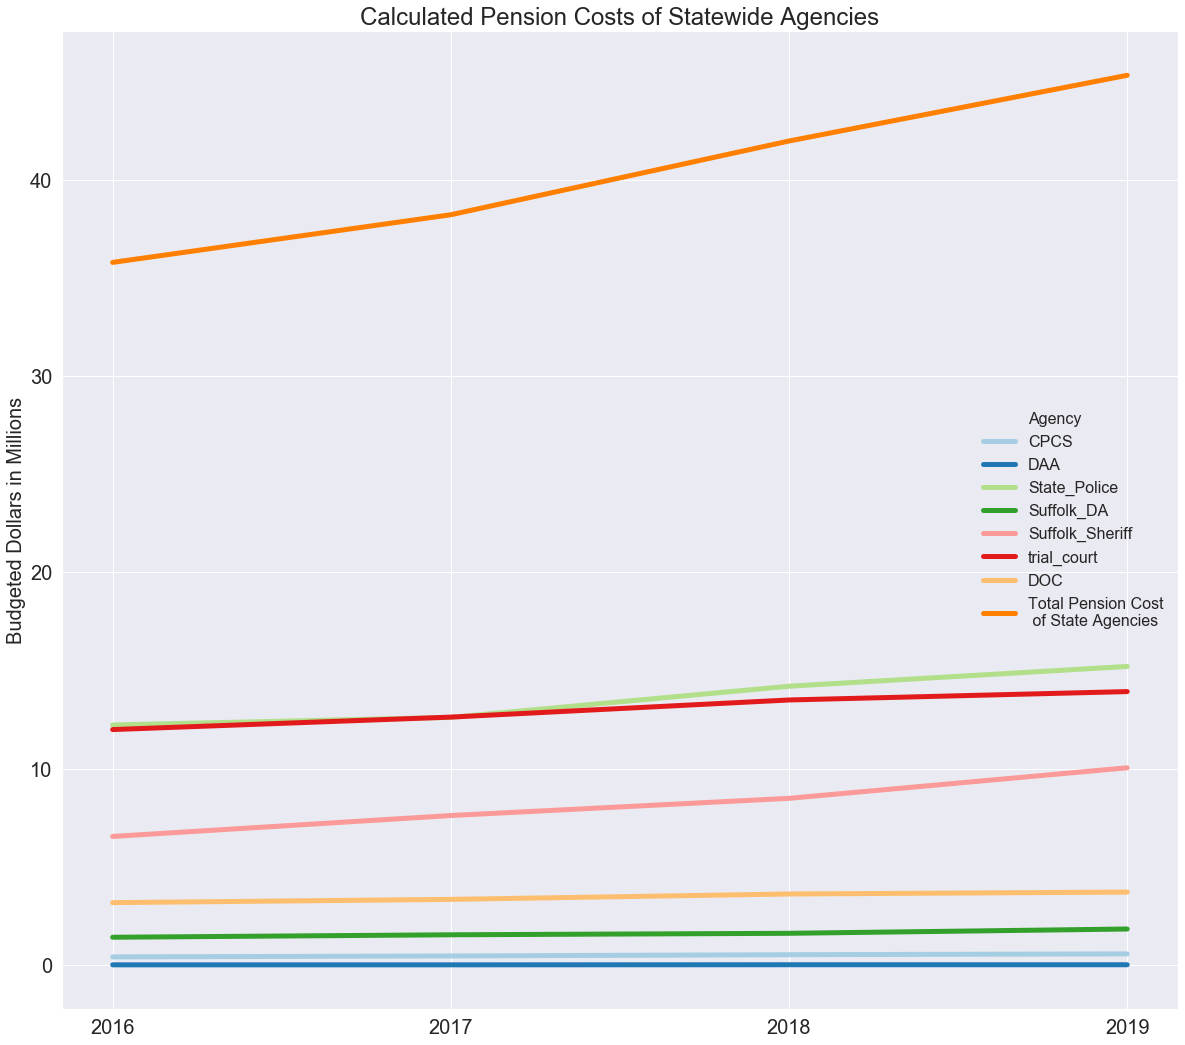

In [30]:
visualize_state_agencies_pensions()

# Municipal Pension Systems
The four municipalities each run thier own pension systems, and none have data on retirement benefit payouts that I could find. They do however have a number in thier yearly budgets of the money they pay in. Teachers in all of Suffolk County get thier pensions through the statewide pension system, and the municipality is responsible for all other city employee salaries. This similarity allows our methodology to be consistent for each municipality. <br>

For each municipality we take the % of non-teacher payroll that goes to cops, and estimate that the % of retirement contributions that end up going to cops is the same. This is likely an underestimate as cops retire earier and have more generous pensions than other city employees, so the ratio of dollars paid out in payroll over the course of thier careers to total retirement benefits paid out is likely lower. 

**Notes on missing data/possible issues**<br>
For Winthrop I couldn't find data on yearly retirement benefits or yearly payroll, so I assumed that Winthrop pays the same ratio of total cop expenditures to cop pension expenditures as Revere does. Winthrop's PD is a tiny department with a yearly budget of less than 4 million so a crude estimation won't hurt much. <br>

Otherwise, the data needed to make these calculations was clean and well-organized. One possible issue is that some guesswork was required to figure out which employees in the Boston payroll are part of the statewide public school retirement system and which are part of the boston system. I used the set of rules that if a employee is assumed get thier pension from the statewide teacher pension system if thier title is "Teacher", "Substitute Teacher", "Principal Elementary", or "Headmaster" or if the name of thier employer has any of the terms "BPS", "K-8", "Middle", "Elementary", or "High School" in it's title. I'm not confident that this rule is correct for each employee. <br>

Another caveat is for Boston and Chelsea the payroll data used comes from the earnings data set, whereas for Revere it comes from the stated payroll numbers in the budget. Thus the % of cop pay number for Revere was arrived at in a different way. This report is the best job I could do with the numbers I could find.

In [31]:
from Full_Project_Reportback_1Ver import visualize_localPD_pensions

,2016,2017,2018,2019
Boston PD,85.652,85.887,101.811,108.950
Chelsea PD,2.768,2.828,2.864,3.107
Revere PD,3.491,3.714,3.878,4.156
Winthrop PD,1.097,1.197,1.337,1.624
Total Pension Costs for Municipal Police Forces,93.007,93.624,109.890,117.837


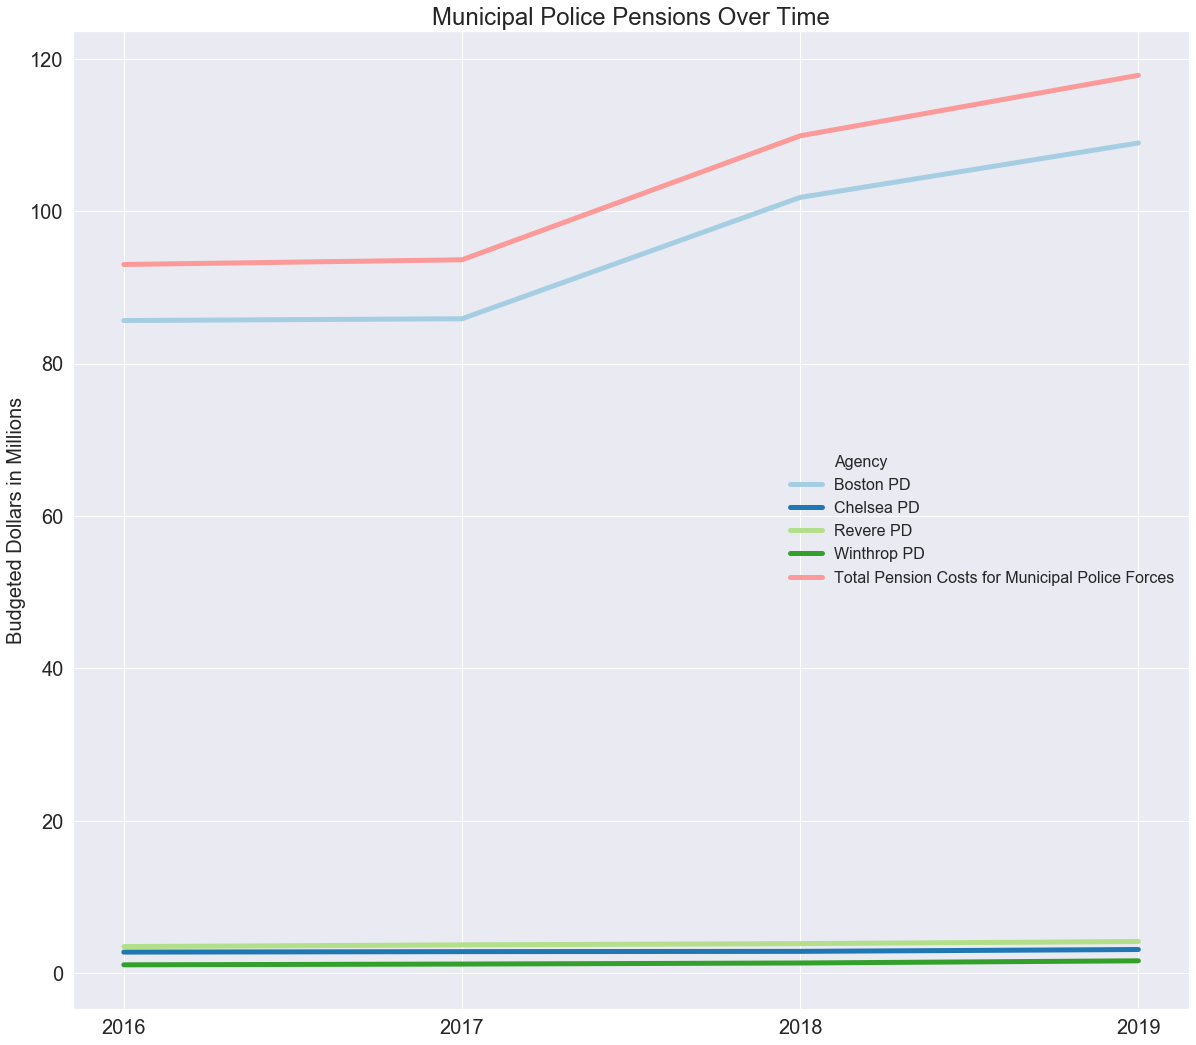

In [32]:
visualize_localPD_pensions()

## Total Pension Costs

In [33]:
from Full_Project_Reportback_1Ver import plot_total_pensions

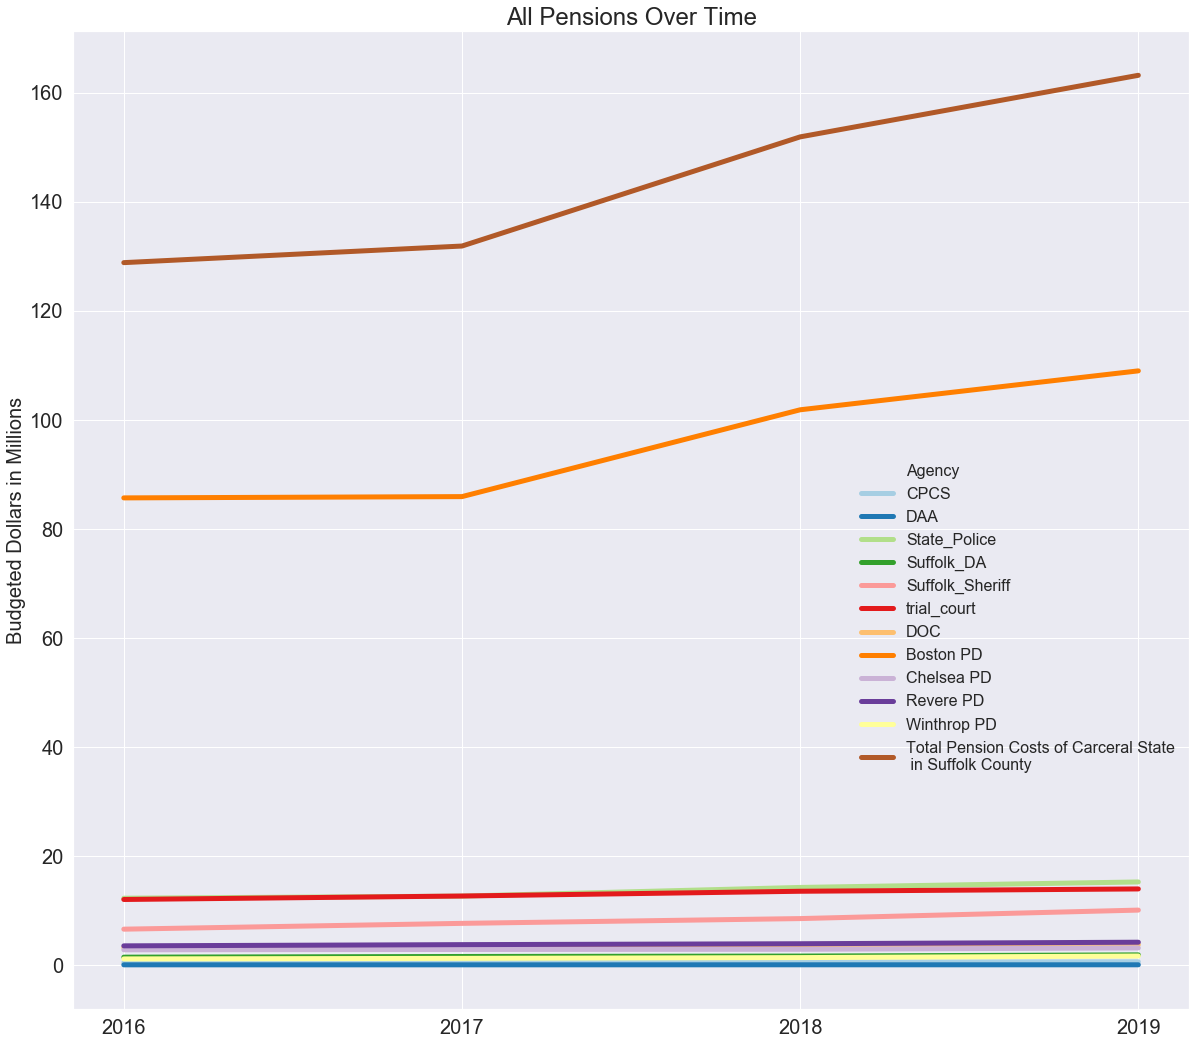

In [34]:
plot_total_pensions()

# Final Summary

In [35]:
from Full_Project_Reportback_1Ver import final_summary


Final Totals Including Pension


,Category,2016,2017,2018,2019
trial_court,Legal,104.578,103.911,109.304,111.203
CPCS,Legal,32.058,33.306,25.834,36.193
DOC,Jails,91.447,93.284,101.167,102.632
Suffolk_DA,Legal,19.667,20.823,21.087,22.811
Suffolk_Sheriff,Jails,111.043,111.063,114.009,116.620
State_Police,State Police,65.138,65.704,71.241,68.980
MBTA Police,State Police,21.106,16.997,18.163,23.730
DAA,Legal,1.182,0.755,0.697,1.301
MA Sheriff's Association,State Police,0.056,0.054,0.055,0.065
Boston PD,Local PD,514.135,524.094,584.695,582.730


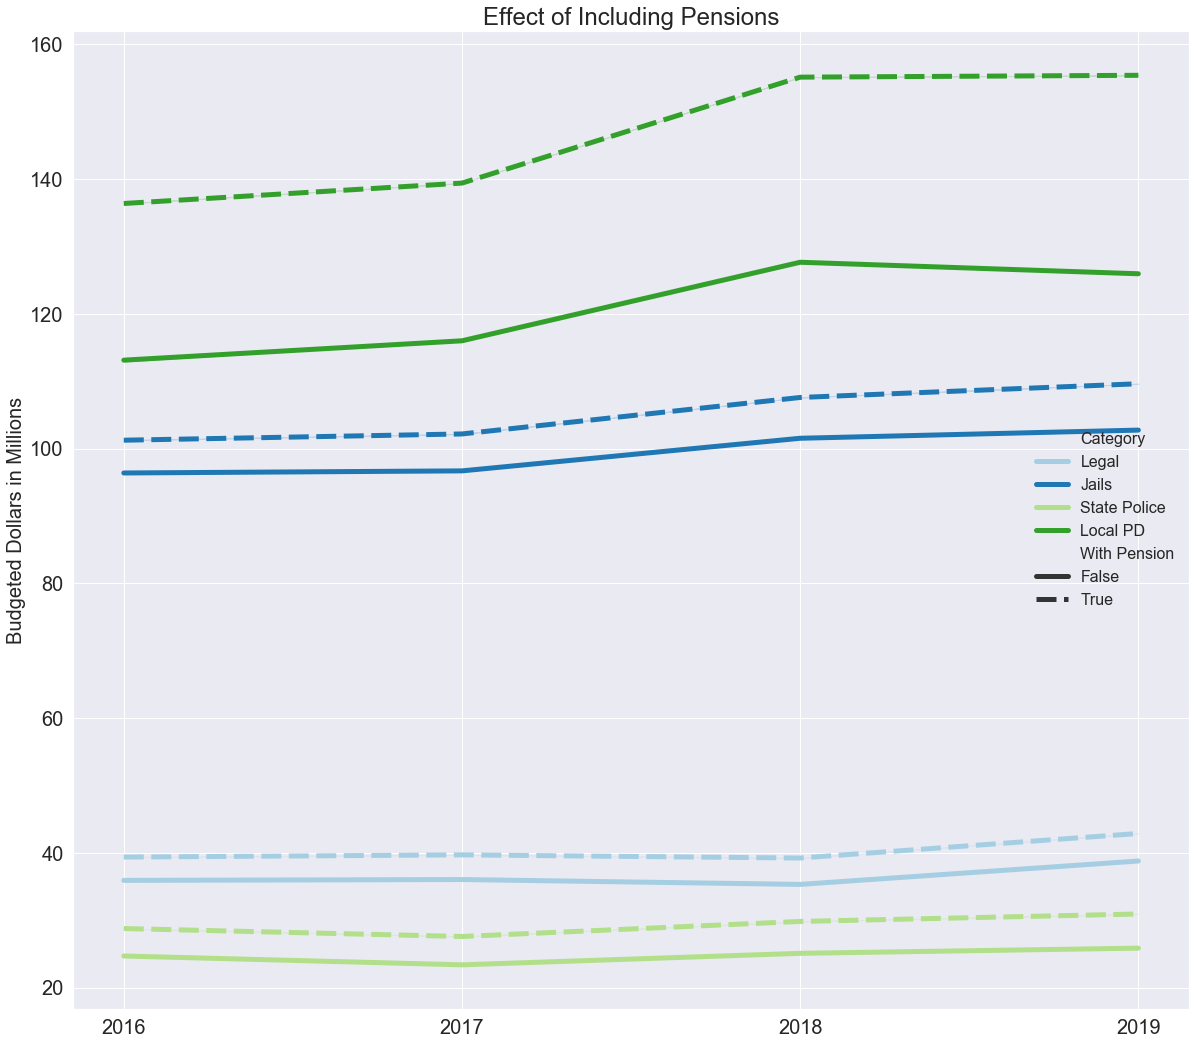

Yearly Cost of SCDAO Case With and Without Including Pension Costs (In Thousands)


,2016,2017,2018,2019
With Pension,,,,
False,28051.092,30840.441,33439.228,35445.384
True,32237.661,35505.198,38898.482,41584.759


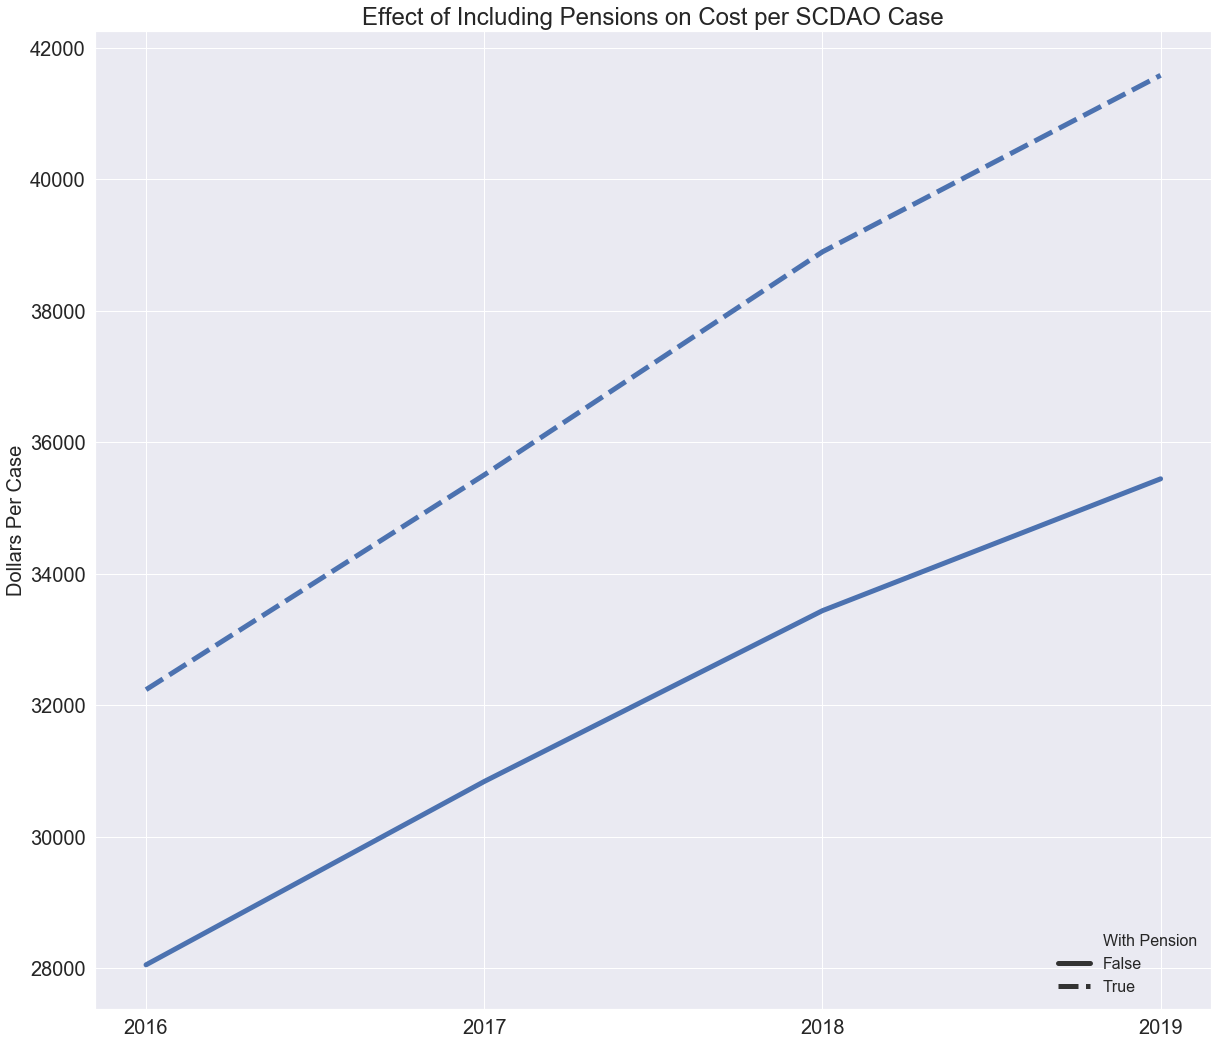

In [37]:
final_summary()

Pension dollars contribute another $4-6k per case each year. The dotted line represents the total cost per case